<a href="https://colab.research.google.com/github/abysse8/F23-Wavelet-Project/blob/main/Final_copy_of_Modified_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Notebook
This notebook demonstrates the construction and training of a simple convolutional neural network (CNN),
specifically designed for image classification tasks. The network utilizes wavelet transforms and explores the impact of
varying sparsity levels on model performance. The code includes model definition, data loading, training, and visualization of results.

TO INSTALL

pip install torch torchvision torchaudio

pip install pywavelets

pip install tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pywt  # PyWavelets for wavelet transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from math import ceil  # Used in the SimpleCNN class

In [3]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

# Test CUDA operation
if torch.cuda.is_available():
    x = torch.tensor([1.0, 2.0])
    print("Original Device:", x.device)
    x = x.to("cuda")
    print("New Device:", x.device)
else:
    print("CUDA is not available.")


PyTorch Version: 2.1.0+cu121
CUDA Available: True
Original Device: cpu
New Device: cuda:0


In [4]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
def to_wavelet_coeffs(data, levels=3, wavelet='db1', mode='symmetric'):
    # Perform wavelet decomposition at the specified levels
    all_coeffs = [0]
    all_coeffs[0], *coeffs = pywt.wavedec2(data.cpu(), wavelet=wavelet, mode=mode, level=levels)
    for detail_level in coeffs:
        all_coeffs.extend(detail_level)
    return all_coeffs


# Custom Dataset class
class WaveletDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Convert image to numpy array and apply wavelet transform
        image_array = np.array(image)
        wavelet_coeffs = to_wavelet_coeffs(image_array)
        return wavelet_coeffs, label

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

dtd = torchvision.datasets.DTD(root='./data', download=True, transform=transform)

# Define a subset of the dataset
subset_indices = np.random.choice(len(dtd), 60, replace=False) # Adjust 1000 to the number of samples you want
dtd_train_subset = Subset(dtd, subset_indices)

# DataLoader for the subset
train_loader_subset = DataLoader(dtd_train_subset, batch_size=1, shuffle=True)

100%|██████████| 625239812/625239812 [00:21<00:00, 29564433.50it/s]


Extracting data/dtd/dtd-r1.0.1.tar.gz to data/dtd


In [6]:
x, lab = next(iter(train_loader_subset))
print(len(x))
y = to_wavelet_coeffs(x)

1


torch.Size([256, 256])


<ipython-input-7-91334232f42d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coeffs = [torch.tensor(item) for item in coeffs]


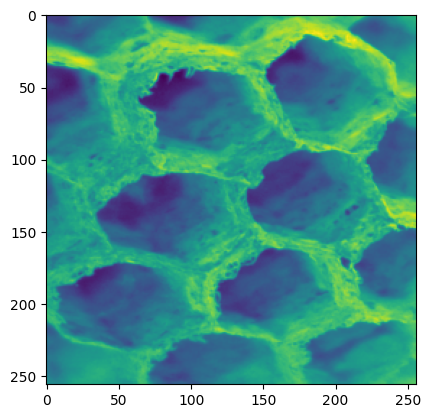

In [7]:
def wavelet_display(coeffs):
  coeffs = [torch.tensor(item) for item in coeffs]
  #print([item.shape for item in coeffs])
  while len(coeffs) > 1:
    coeffs[0] = torch.concat((torch.concat((coeffs[0],coeffs[1]), dim=-1), torch.concat((coeffs[2],coeffs[3]), dim=-1)), dim=-2)
    del coeffs[1:4]
  coeffs = coeffs[0]
  print(coeffs[0].shape)
  plt.imshow(torch.movedim(coeffs[0], 0, -1))

wavelet_display(x)

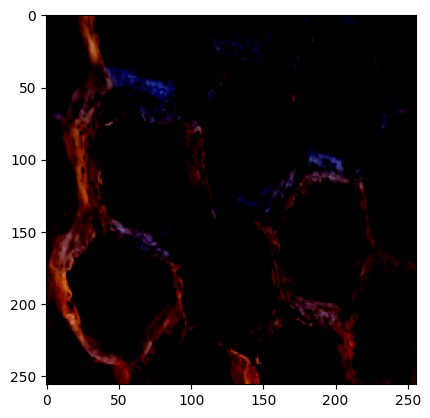

In [8]:
# prompt: write code for me to display an image

plt.imshow(torch.movedim(x[0], 0, -1))


torch.Size([3, 256, 256])


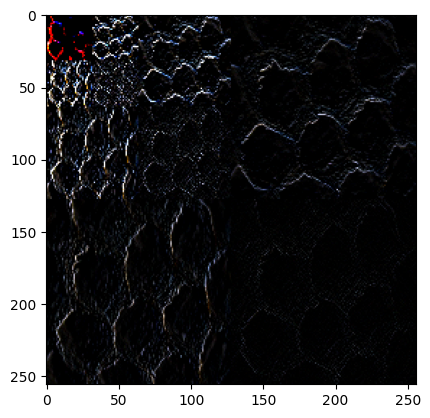

In [9]:
wavelet_display(y)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

class SimpleCNN(nn.Module):
    def __init__(self, mode='normal', num_kernels=32, num_classes=47, sparse=1):
        super(SimpleCNN, self).__init__()
        self.mode = mode
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, max(1, ceil(num_kernels*sparse)), kernel_size=3, stride=1, padding=1)
        self.conv1a = nn.Conv2d(3, max(1, ceil(num_kernels * sparse*0.5)), kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(3, max(1, ceil(num_kernels * sparse*0.5)), kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(max(1, ceil(num_kernels * sparse)), num_kernels, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # Calculate flattened size dynamically
        dummy_input = torch.randn(1, 3, 64, 64)
        dummy_input = self.conv2(self.pool(F.relu(self.conv1(dummy_input))))
        dummy_input = dummy_input.view(1,-1)
        self.flattened_size = dummy_input.shape[1]

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def separate_channels(self, x1, x2):
      # Apply convolution and ReLU to each input
      x1 = F.relu(self.conv1a(x1))
      x2 = F.relu(self.conv1b(x2))

      # Concatenate along the channel dimension
      x = torch.cat((x1, x2), dim=1)  # dim=1 for channel dimension
      # Pooling can be applied after concatenation
      return self.pool(x)

    def forward_phase1(self, x):
        if self.mode == 'normal':
            per = torch.count_nonzero(x)
            x = self.pool(F.relu(self.conv1(self.pool(x))))  # Apply convolution and pooling
        elif self.mode == 'modified':
            x = to_wavelet_coeffs(x, levels=1)
            x = [torch.tensor(item).to(device) for item in x]
            for item in x:
              threshold = np.percentile(item.cpu(), 90)
              item[item<threshold] = 0
            per = torch.tensor([torch.count_nonzero(item) for item in x])
            per = torch.sum(per)
            x = self.separate_channels(x[0], x[1]+x[2]+x[3])
        return per, x

    def forward_phase2(self, x):
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward(self, x):
        self.amount = torch.numel(x)
        per, x = self.forward_phase1(x)
        x = self.forward_phase2(x)
        return per,x

def check_size():
    model_normal = SimpleCNN(mode='normal', num_kernels=32, sparse=0.5, num_classes=47)
    model_modified = SimpleCNN(mode='modified', num_kernels=32, sparse=0.5, num_classes=47)

    dummy_input = torch.randn(1, 3, 128,128)

    print("----------Phase 1----------")
    output_normal = model_normal.forward_phase1(dummy_input)
    output_modified = model_modified.forward_phase1(dummy_input)
    print(f"Unseparated channels:{output_normal.shape}")
    print(f"Separated channels:{output_modified.shape}")
    print("----------Phase 2----------")
    output_normal = model_normal.forward_phase2(output_normal)
    output_modified = model_modified.forward_phase2(output_modified)
    print(f"Unseparated channels:{output_normal.shape}")
    print(f"Separated channels:{output_modified.shape}")
    return output_normal.size() == output_modified.size()

# Example usage
#sizes_match = check_size()
#print("Do the sizes match after the first phase for both modes? ", sizes_match)

In [11]:
from tqdm import tqdm

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


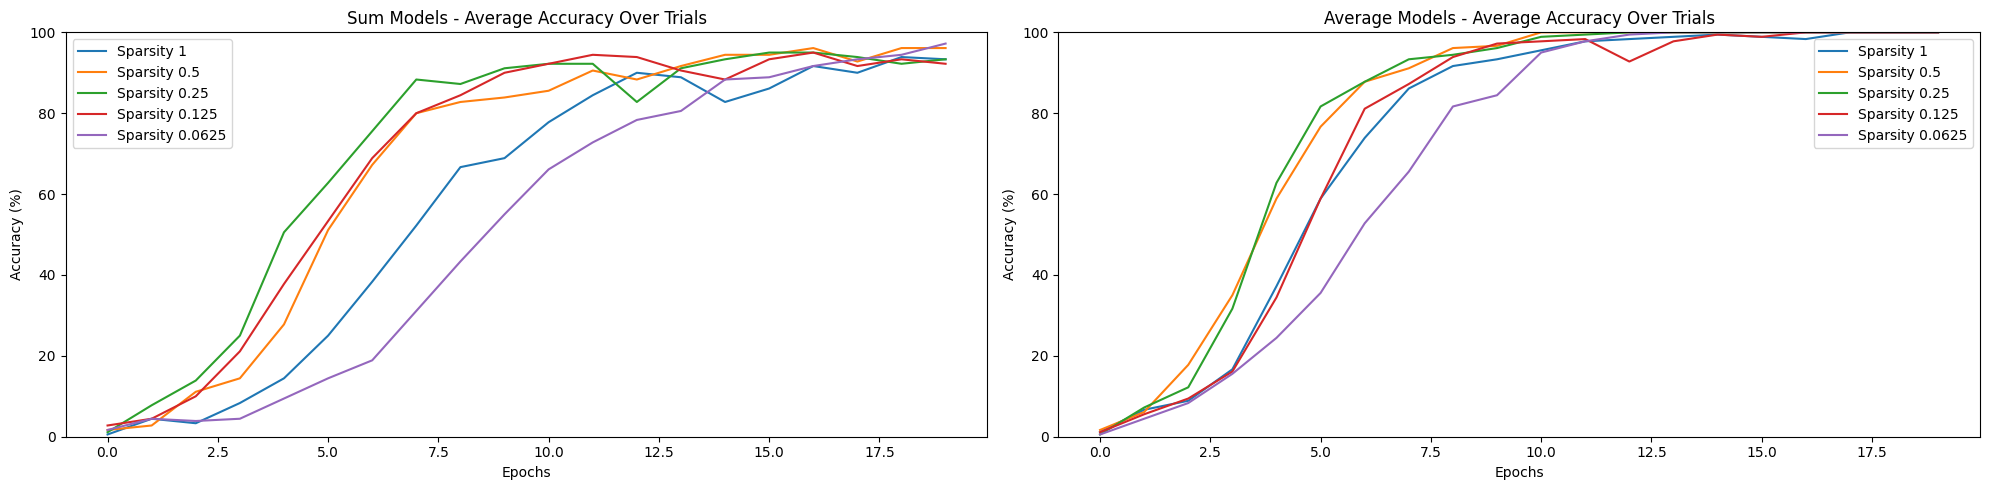

In [12]:
def train_model(model, criterion, optimizer, epochs):
    model.train()
    loss_history = []
    accuracy_history = []

    for epoch in tqdm(range(epochs)):
        total = 0
        correct = 0
        epoch_loss = 0.0
        for inputs, labels in train_loader_subset:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            nonzero, outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_history.append(epoch_loss / total)
        accuracy_history.append(100 * correct / total)

    return nonzero, accuracy_history

# Training loop
epochs = 20
num_trials = 3

fig, (ax_sum, ax_avg) = plt.subplots(1, 2, figsize=(20, 5))

for sparsity_index in [1, 0.5, 0.25, 0.125, 0.0625]:
    all_accuracies_average = []
    all_accuracies_details = []
    nonzero_average = 0
    nonzero_details = 0

    for trial in range(num_trials):
        model_average = SimpleCNN(mode='normal', sparse=sparsity_index).to(device)
        model_details = SimpleCNN(mode='modified', sparse=sparsity_index).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer_average = torch.optim.Adam(model_average.parameters(), lr=0.001)
        optimizer_details = torch.optim.Adam(model_details.parameters(), lr=0.001)

        iii, accuracy_history_average = train_model(model_average, criterion, optimizer_average, epochs=epochs)
        jjj, accuracy_history_details = train_model(model_details, criterion, optimizer_details, epochs=epochs)

        nonzero_average = nonzero_average + iii
        nonzero_details = nonzero_details + jjj

        all_accuracies_average.append(accuracy_history_average)
        all_accuracies_details.append(accuracy_history_details)

    avg_accuracy_history_average = [sum(epoch_accuracies) / num_trials for epoch_accuracies in zip(*all_accuracies_average)]
    avg_accuracy_history_details = [sum(epoch_accuracies) / num_trials for epoch_accuracies in zip(*all_accuracies_details)]

    ax_sum.plot(avg_accuracy_history_average, label=f'Sparsity {sparsity_index}')
    ax_avg.plot(avg_accuracy_history_details, label=f'Sparsity {sparsity_index}')

ax_sum.set_xlabel('Epochs')
ax_sum.set_ylabel('Accuracy (%)')
ax_sum.set_title('Sum Models - Average Accuracy Over Trials')
ax_sum.legend()

ax_sum.set_ylim(0, 100)
ax_avg.set_ylim(0, 100)

ax_avg.set_xlabel('Epochs')
ax_avg.set_ylabel('Accuracy (%)')
ax_avg.set_title('Average Models - Average Accuracy Over Trials')
ax_avg.legend()

plt.tight_layout()
plt.show()

In [14]:
nonzero_average/model_average.amount, nonzero_details/model_average.amount

(tensor(3., device='cuda:0'), tensor(0.3008))